### **Preparación del contexto:**

*   Inicialización del entorno y el modelo generativo:

*   Configura Vertex AI con el proyecto y la región especificada.

* Inicializa el modelo generativo Gemini 1.5 Flash para responder a consultas complejas.



### **Construye un contexto detallado para el modelo generativo, que incluye:**

* La consulta del usuario.
* Una lista de productos relevantes obtenidos de BigQuery, incluyendo:
  1. Nombre del producto.
  2. Descripción.
  3. Composición.
  4. Instrucciones de uso.

### **Pregunta al modelo generativo:**

Se formula una pregunta específica para el modelo, solicitando que recomiende un producto basado en los criterios del usuario.
El modelo debe ignorar productos que no cumplan con los requisitos.

### **Generación de la respuesta:**

El modelo procesa el contexto y la pregunta para generar una respuesta.
La respuesta puede incluir una recomendación, explicaciones y detalles relevantes del producto

### **Mostrar la respuesta:**

La respuesta generada por el modelo se imprime para que el usuario la visualice.
Este flujo es útil para crear un asistente conversacional que proporcione recomendaciones personalizadas y justificadas, enriquecidas con datos de productos.

In [4]:
from typing import List, Optional
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from google.cloud import aiplatform

# Inicializar Vertex AI
aiplatform.init(project="dataton-2024-team-13-cofares", location="us-central1")


In [5]:
# Inicializa el cliente de la API de Gemini
gemini_client = aiplatform.gapic.PredictionServiceClient()

# Importaciones

In [6]:
from typing import List, Optional
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from google.cloud import aiplatform, bigquery, storage
import os
import pandas as pd
from IPython.display import display, Image as IPImage
from vertexai.preview.generative_models import GenerativeModel, Image

In [9]:
import vertexai

In [30]:
# Inicializar el entorno
PROJECT_ID = "dataton-2024-team-13-cofares"
REGION = "us-central1"
vertexai.init(project=PROJECT_ID, location=REGION)

# Inicializar el entorno
PROJECT_ID = "dataton-2024-team-13-cofares"
REGION = "us-central1"
vertexai.init(project=PROJECT_ID, location=REGION)

# Inicializar el modelo generativo
generative_model = GenerativeModel("gemini-1.5-flash-001")

# Función para descargar imágenes temporalmente
def descargar_imagen_de_gcs(gcs_uri, local_path):
    """Descargar una imagen desde GCS a una ruta local."""
    from google.cloud import storage
    client = storage.Client()
    bucket_name, blob_name = gcs_uri.replace("gs://", "").split("/", 1)
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(local_path)
    return local_path

from google.cloud import bigquery

# Inicializar cliente de BigQuery
client = bigquery.Client()

def consultar_bigquery(query_text, expandir_busqueda=False):
    """Consulta BigQuery y devuelve un DataFrame con los productos relevantes."""
    # Si expandir_busqueda es True, reducimos las restricciones de búsqueda
    fraction_lists_to_search = 0.05 if expandir_busqueda else 0.01

    query = f"""
    WITH top_results AS (
      SELECT
        CAST(base.codigo_web AS STRING) AS result_id
      FROM VECTOR_SEARCH(
        TABLE `dataset_us.embeddings`,
        'ml_generate_embedding_result',
        (
          SELECT ml_generate_embedding_result, content AS query
          FROM ML.GENERATE_EMBEDDING(
            MODEL `dataset_us.embedding_model`,
            (SELECT '{query_text}' AS content))
        ),
        top_k => 5, options => '{{"fraction_lists_to_search": 0.01}}'
      )
    )
    SELECT
      original_table.*
    FROM `dataset_us.test_table_9k` AS original_table
    JOIN top_results
    ON REGEXP_EXTRACT(original_table.`codigo web`, r'[0-9]+$') = top_results.result_id;
    """
    # Ejecutar la consulta en BigQuery
    query_job = client.query(query)
    return query_job.to_dataframe()


def generar_respuesta_con_imagenes_gemini(query_text, historial=None):
    """Genera una respuesta basada en la consulta del usuario y descarga solo la imagen del producto recomendado."""
    if historial is None:
        historial = []

    # Añadir la consulta actual al historial
    historial.append(f"Usuario: {query_text}")

    # Consultar BigQuery para obtener productos relevantes
    resultados_bigquery = consultar_bigquery(query_text)
    # Si hay menos de 3 productos, realizar una nueva consulta con rango ampliado
    if len(resultados_bigquery) < 3:
        resultados_bigquery = consultar_bigquery(query_text, expandir_busqueda=True)
    contexto = """
Eres un asistente conversacional experto en productos, que ayuda a los usuarios a encontrar opciones basadas en sus necesidades específicas.
Mantén un lenguaje natural, fluido y profesional.
Recuerda la conversación previa y refina tus respuestas basándote en las preguntas adicionales o nuevos datos del usuario.
Si no encuentras información relevante, solicita más detalles al usuario de manera educada.
"""

# Agregar historial de interacción
    for interaccion in historial:
        contexto += f"\n{interaccion}"

# Incluir productos relevantes encontrados
    contexto += "\n\nProductos relevantes encontrados:"
    for _, row in resultados_bigquery.iterrows():
        contexto += f"""
    Producto: {row['nombre del producto']}
    Descripción: {row['informacion del producto']}
    Composición: {row['composicion']}
    Código Web: {row['codigo web']}
    ---"""

    pregunta = """
Basándote en la consulta actual del usuario y el historial previo:
1. Responde de manera específica y directa a la pregunta del usuario.
2. Si no tienes suficientes datos, muestra las opciones disponibles sin pedir más información adicional.
3. Si es necesario, recomienda un producto relevante y explica por qué es adecuado.
4. Descartar otros productos solo si es útil para la pregunta actual.
5. Si necesitas más información, solicita datos adicionales de forma clara y educada.
6. Al final, pregunta: "¿Es lo que buscabas?" para fomentar la interacción.
"""



    # Generar contenido con el texto
    response = generative_model.generate_content([contexto + pregunta])

    # Identificar el código web en la respuesta
    producto_recomendado = None
    for _, row in resultados_bigquery.iterrows():
        if str(row['codigo web']) in response.text:
            producto_recomendado = row['codigo web']
            imagen_uri = row.get("imagen_uri", None)
            break

    # Descargar la imagen del producto recomendado si existe
    imagen_recomendada = None
    if producto_recomendado and imagen_uri:
        local_path = f"/tmp/imagen_{producto_recomendado}.jpg"
        try:
            descargar_imagen_de_gcs(imagen_uri, local_path)
            imagen_recomendada = local_path
        except Exception as e:
            print(f"Error al descargar la imagen del producto recomendado ({imagen_uri}): {e}")


    historial.append(f"Asistente: {response.text}")


    return response.text, imagen_recomendada, historial


# Ejemplo de uso interactivo
if __name__ == "__main__":
    historial = []
    while True:
        query_text = input("Usuario: ")
        respuesta, imagen, historial = generar_respuesta_con_imagenes_gemini(query_text, historial)
        print(f"Asistente: {respuesta}")
        if imagen:
            print(f"Imagen recomendada guardada en: {imagen}")


Usuario: querria proteccion para las relaciones sexuales con sabor a fresa


ValueError: Cannot get the response text.
Cannot get the Candidate text.
Response candidate content has no parts (and thus no text). The candidate is likely blocked by the safety filters.
Content:
{}
Candidate:
{
  "finish_reason": "SAFETY",
  "safety_ratings": [
    {
      "category": "HARM_CATEGORY_HATE_SPEECH",
      "probability": "NEGLIGIBLE",
      "probability_score": 0.103515625,
      "severity": "HARM_SEVERITY_NEGLIGIBLE",
      "severity_score": 0.071777344
    },
    {
      "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
      "probability": "NEGLIGIBLE",
      "probability_score": 0.17675781,
      "severity": "HARM_SEVERITY_LOW",
      "severity_score": 0.22363281
    },
    {
      "category": "HARM_CATEGORY_HARASSMENT",
      "probability": "NEGLIGIBLE",
      "probability_score": 0.106933594,
      "severity": "HARM_SEVERITY_NEGLIGIBLE",
      "severity_score": 0.056640625
    },
    {
      "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
      "probability": "HIGH",
      "blocked": true,
      "probability_score": 0.91796875,
      "severity": "HARM_SEVERITY_MEDIUM",
      "severity_score": 0.640625
    }
  ]
}
Response:
{
  "candidates": [
    {
      "finish_reason": "SAFETY",
      "safety_ratings": [
        {
          "category": "HARM_CATEGORY_HATE_SPEECH",
          "probability": "NEGLIGIBLE",
          "probability_score": 0.103515625,
          "severity": "HARM_SEVERITY_NEGLIGIBLE",
          "severity_score": 0.071777344
        },
        {
          "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
          "probability": "NEGLIGIBLE",
          "probability_score": 0.17675781,
          "severity": "HARM_SEVERITY_LOW",
          "severity_score": 0.22363281
        },
        {
          "category": "HARM_CATEGORY_HARASSMENT",
          "probability": "NEGLIGIBLE",
          "probability_score": 0.106933594,
          "severity": "HARM_SEVERITY_NEGLIGIBLE",
          "severity_score": 0.056640625
        },
        {
          "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
          "probability": "HIGH",
          "blocked": true,
          "probability_score": 0.91796875,
          "severity": "HARM_SEVERITY_MEDIUM",
          "severity_score": 0.640625
        }
      ]
    }
  ],
  "usage_metadata": {
    "prompt_token_count": 1294,
    "total_token_count": 1294
  },
  "model_version": "gemini-1.5-flash-001"
}

pasta de dientes para niños alergicos al fluor
Entiendo que buscas una pasta de dientes para niños alérgicos al flúor. De los productos que encontré, te recomiendo **Fluocaril Gel Kids Fresa 50 ml** (Código Web: 196329). 

Este producto es ideal porque está **especialmente formulado para niños de 2 a 6 años** y además **no contiene flúor**, lo que lo hace perfecto para niños con alergia a este componente.  

Descarto los demás productos por las siguientes razones:

* **Farline Pasta Encías 125 ml:** Contiene fluoruro sódico en su composición, por lo que no es adecuado para niños alérgicos.
* **Fluor Kin Pasta Fresa 75 ml:** También contiene fluoruro sódico, por lo que no es una opción viable.
* **Lacer Oros Fluor Pasta 125 ml:**  Contiene fluoruro sódico y monofluorofosfato sódico, por lo que tampoco es adecuado.
* **Gum Kids Pasta Fresa 50 ml:**  Aunque está formulado para niños, contiene fluoruro sódico, por lo que no es apto para niños con alergia a este componente.

Espero que esta

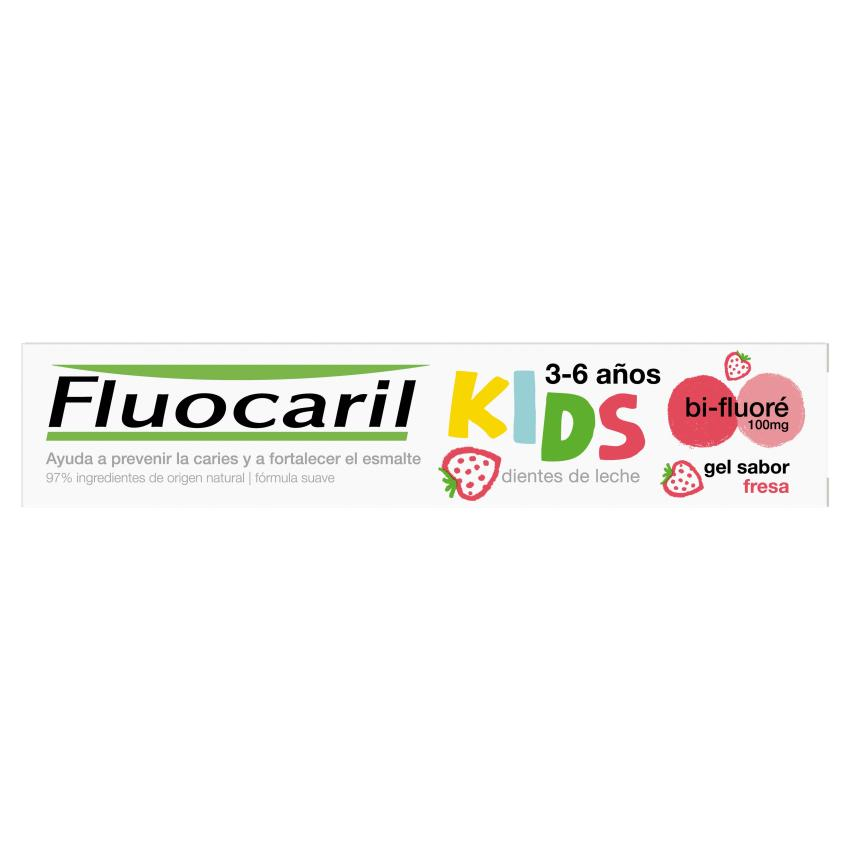

In [21]:
respuesta_modelo, imagen_recomendada = generar_respuesta_con_imagenes_gemini(input())

# Mostrar la respuesta
print(respuesta_modelo)

# Mostrar la imagen correspondiente al producto recomendado
if imagen_recomendada:
        display(IPImage(filename=imagen_recomendada))
else:
        print("No hay imagen disponible para el producto recomendado.")
